In [1]:
import pandas as pd
import numpy as np
import os.path as op
import unicodedata
import sys
from gensim.models import FastText
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_predict, StratifiedShuffleSplit, train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier


basename = "/home/adrian/PhD/Tweet-Classification-Diabetes-Distress/"
path_utils = op.join(basename , "utils")
sys.path.insert(0, path_utils)

from sys_utils import load_library
from tweet_utils import *

from preprocess import Preprocess
prep = Preprocess()

model_we = FastText.load("/home/adrian/PhD/Data/FastText_embedding_20190703/ft_wordembeddings_dim300_minCount5_URL-User-toConstant_iter10_20190703")


[nltk_data] Downloading package punkt to /home/adrian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/adrian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/adrian/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,user_name,tweet,"personal (0=no, 1=yes)",tweet_proc
0,_JenniferLyne,Seven yoga poses for diabetes https://t.co/B68...,0,"['seven', 'yoga', 'pose', 'diabet', 'URL']"
1,marguerite3636d,#reversediabetes now ➤ https://t.co/PDEsqoaou8...,0,"['reversediabet', 'URL', 'could', 'tb', 'vacci..."
2,amandajohnjones,The occurrence of #hypoglycemia can pose a ser...,0,"['occurr', 'hypoglycemia', 'pose', 'serious', ..."
3,Healthcheqs,Others talk - we help! Improve public #health ...,0,"['other', 'talk', 'help', 'improv', 'public', ..."
4,70_130,A three-month road trip (by a real diabetic) t...,1,"['three-month', 'road', 'trip', 'real', 'diabe..."


In [8]:
trainingData = pd.read_csv("/home/adrian/PhD/Data/WDDS/manually_labeled_tweets_instVSpers_25072018.csv", sep=";")
#trainingData = pd.read_csv("/home/adrian/PhD/Data/WDDS/manually_labeled_users_instVSpers_MoreInstTweets_30072018.csv", sep=";")

trainingData.head(5)

,user_name,tweet,"personal (0=no, 1=yes)",tweet_proc
0,_JenniferLyne,Seven yoga poses for diabetes https://t.co/B68...,0,"['seven', 'yoga', 'pose', 'diabet', 'URL']"
1,marguerite3636d,#reversediabetes now ➤ https://t.co/PDEsqoaou8...,0,"['reversediabet', 'URL', 'could', 'tb', 'vacci..."
2,amandajohnjones,The occurrence of #hypoglycemia can pose a ser...,0,"['occurr', 'hypoglycemia', 'pose', 'serious', ..."
3,Healthcheqs,Others talk - we help! Improve public #health ...,0,"['other', 'talk', 'help', 'improv', 'public', ..."
4,70_130,A three-month road trip (by a real diabetic) t...,0,"['three-month', 'road', 'trip', 'real', 'diabe..."


In [2]:
print("Vector size:", model_we.vector_size)
print("Vocab size:", len(model_we.wv.vocab))

Vector size: 300
Vocab size: 266230


In [9]:
def preprocess_tweet(tweet):
    tweet = prep.replace_hashtags_URL_USER(tweet, mode_URL="replace", mode_Mentions="replace")
    tweet = prep.tokenize(tweet)
    return tweet

    
label = "personal (0=no, 1=yes)"
labels = trainingData[label]
tweets_raw = trainingData["tweet"]

# Adapt preprocessing function depending on which preprocessed word embeddings you use!
V = np.array([tweet_vectorizer(preprocess_tweet(tweet), model_we) for tweet in tweets_raw])


# remove the tweets that are empty because there is no word embedding
VV = [(tweet, label) for tweet, label in zip(V, labels) if len(tweet) > 0]

labels = pd.DataFrame([tup[1] for tup in VV])
V = [tup[0] for tup in VV]
len(V)

1884

In [10]:

# choose algo:
#---------------------------------------------------------------------------
modelAlgo = "SVC"

if modelAlgo == "MultinomialNB":
    model = MultinomialNB(random_state=0)
elif modelAlgo == "SVC":
    model = SVC(random_state=0)
elif modelAlgo == "logReg":
    model = LogisticRegression(random_state=0)
elif modelAlgo == "RandomForest" :
    model = RandomForestClassifier(random_state=0)
elif modelAlgo == "XGBoost" :
    model = XGBClassifier(random_state=0)
elif modelAlgo == "MLP" :
    model = MLPClassifier(early_stopping=True, batch_size=32, random_state=0)
#model = KerasClassifier(build_fn=create_model, epochs=10)

pipeline  = Pipeline([
                    ('model', model),
                ])


# parameter grid for grid search by using fastText embeddings
parameters = {

    #               # param for LogisticRegression
                   #'model__C' : [10, 3, 1.0, 0.8, 0.5, 0.1],
                   #'model__tol' : [1e-2, 1e-3, 1e-4, 1e-5],
    #
    #               # param for SVC
                   'model__kernel' : ["linear", "poly", "rbf"],
                   'model__C' : [15.0, 10.0, 8.0, 5.0, 1.0],
                   'model__tol' : [1e-1, 1e-2, 1e-3, 1e-4],
                   "model__gamma":["auto", 0.01, 0.1, 1.0]
    #
    #               # param for RandomForestClassifier
                   #'model__n_estimators' : [70, 80, 100, 120],
                   #'model__criterion' : ['gini', 'entropy'],
                   #'model__max_features' : ['auto', 'log2'],
                   #'model__max_depth' : [ 8, 10, 20]
    #
    #               # param for XGBoost Best: 0.910828 using {'model__learning_rate': 0.05, 'model__reg_alpha': 0, 'model__max_depth': 3, 'model__reg_lambda': 1.5, 'model__n_estimators': 300}
                   #'model__max_depth' : [3,4],
                   #'model__learning_rate' : [0.01, 0.05, 0.1],
                   #'model__booster' : ["gblinear"], #["gbtree", "gblinear", "dart"],
                   #'model__gamma' : [0, 0.01],
                   #'model__n_estimators' : [100, 200, 300],
                   #'model__reg_alpha' : [0, 0.1],
                   #'model__reg_lambda' : [0.5, 1.0, 1.5]
}


In [11]:

X_train, X_test, y_train, y_test = train_test_split(np.vstack(V), labels.values.ravel(), test_size=0.3, random_state=0)

print("Start Grid search...")
grid = GridSearchCV(pipeline, parameters, cv=10, n_jobs=-1, verbose=2, scoring="recall")#, scoring="roc_auc") # recall, f1, roc_auc
grid.fit(X_train, y_train)
print("\nBest: %f using %s" % (grid.best_score_, grid.best_params_))

y_pred = grid.best_estimator_.predict(X_test)
print("F1-Score:", f1_score(y_test, y_pred))
print("Precision: ",precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))    
print("Accuracy: ", accuracy_score(y_test, y_pred)) 
print("roc auc: ", roc_auc_score(y_test, y_pred))   
print("Performance overall: ")
print(classification_report(y_test, y_pred))



Start Grid search...
Fitting 10 folds for each of 240 candidates, totalling 2400 fits

Best: 0.945238 using {'model__C': 15.0, 'model__gamma': 0.1, 'model__kernel': 'poly', 'model__tol': 0.1}
F1-Score: 0.9204545454545456
Precision:  0.9135338345864662
Recall:  0.9274809160305344
Accuracy:  0.9257950530035336
roc auc:  0.9259115106468462
Performance overall: 
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       304
           1       0.91      0.93      0.92       262

    accuracy                           0.93       566
   macro avg       0.93      0.93      0.93       566
weighted avg       0.93      0.93      0.93       566



In [ ]:
# personal tweets

# SVC - scoring none
Best: 0.922612 using {'model__C': 10.0, 'model__gamma': 0.1, 'model__kernel': 'rbf', 'model__tol': 0.01}
F1-Score: 0.9149338374291115
Precision:  0.9063670411985019
Recall:  0.9236641221374046
Accuracy:  0.9204946996466431
roc auc:  0.9207136400160707
Performance overall: 
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       304
           1       0.91      0.92      0.91       262

    accuracy                           0.92       566
   macro avg       0.92      0.92      0.92       566
weighted avg       0.92      0.92      0.92       566

# SVC - scoring recall
Best: 0.945238 using {'model__C': 15.0, 'model__gamma': 0.1, 'model__kernel': 'poly', 'model__tol': 0.1}
F1-Score: 0.9204545454545456
Precision:  0.9135338345864662
Recall:  0.9274809160305344
Accuracy:  0.9257950530035336
roc auc:  0.9259115106468462
Performance overall: 
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       304
           1       0.91      0.93      0.92       262

    accuracy                           0.93       566
   macro avg       0.93      0.93      0.93       566
weighted avg       0.93      0.93      0.93       566


# log rec - scoring none
Best: 0.922600 using {'model__C': 3, 'model__tol': 0.01}
F1-Score: 0.9219047619047619
Precision:  0.9201520912547528
Recall:  0.9236641221374046
Accuracy:  0.9275618374558304
roc auc:  0.9272925873844918
Performance overall: 
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       304
           1       0.92      0.92      0.92       262

    accuracy                           0.93       566
   macro avg       0.93      0.93      0.93       566
weighted avg       0.93      0.93      0.93       566

# log reg - scoring recall
Best: 0.922709 using {'model__C': 1.0, 'model__tol': 0.01}
F1-Score: 0.9204545454545456
Precision:  0.9135338345864662
Recall:  0.9274809160305344
Accuracy:  0.9257950530035336
roc auc:  0.9259115106468462
Performance overall: 
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       304
           1       0.91      0.93      0.92       262

    accuracy                           0.93       566
   macro avg       0.93      0.93      0.93       566
weighted avg       0.93      0.93      0.93       566

# random forest - scoring none
Best: 0.911248 using {'model__criterion': 'gini', 'model__max_depth': 20, 'model__max_features': 'log2', 'model__n_estimators': 120}
F1-Score: 0.8927875243664717
Precision:  0.9123505976095617
Recall:  0.8740458015267175
Accuracy:  0.9028268551236749
roc auc:  0.9008386902370429
Performance overall: 
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       304
           1       0.91      0.87      0.89       262

    accuracy                           0.90       566
   macro avg       0.90      0.90      0.90       566
weighted avg       0.90      0.90      0.90       566


# random forest - scoring recall
Best: 0.906656 using {'model__criterion': 'entropy', 'model__max_depth': 8, 'model__max_features': 'auto', 'model__n_estimators': 100}
F1-Score: 0.9169811320754717
Precision:  0.9067164179104478
Recall:  0.9274809160305344
Accuracy:  0.9222614840989399
roc auc:  0.9226220369626357
Performance overall: 
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       304
           1       0.91      0.93      0.92       262

    accuracy                           0.92       566
   macro avg       0.92      0.92      0.92       566
weighted avg       0.92      0.92      0.92       566

# xgboost - scoring none 
Best: 0.692708 using {'model__booster': 'gblinear', 'model__gamma': 0, 'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__reg_alpha': 0, 'model__reg_lambda': 0.5}
F1-Score: 0.4497041420118343
Precision:  1.0
Recall:  0.2900763358778626
Accuracy:  0.6713780918727915
roc auc:  0.6450381679389313
Performance overall: 
              precision    recall  f1-score   support

           0       0.62      1.00      0.77       304
           1       1.00      0.29      0.45       262

    accuracy                           0.67       566
   macro avg       0.81      0.65      0.61       566
weighted avg       0.80      0.67      0.62       566

# xgboost - scoring recall
Best: 0.349616 using {'model__booster': 'gblinear', 'model__gamma': 0, 'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__reg_alpha': 0, 'model__reg_lambda': 0.5}
F1-Score: 0.4497041420118343
Precision:  1.0
Recall:  0.2900763358778626
Accuracy:  0.6713780918727915
roc auc:  0.6450381679389313
Performance overall: 
              precision    recall  f1-score   support

           0       0.62      1.00      0.77       304
           1       1.00      0.29      0.45       262

    accuracy                           0.67       566
   macro avg       0.81      0.65      0.61       566
weighted avg       0.80      0.67      0.62       566


In [ ]:
# personal users

# SVC - scoring recall
Best: 0.791414 using {'model__C': 15.0, 'model__gamma': 0.01, 'model__kernel': 'rbf', 'model__tol': 0.1}
F1-Score: 0.7912087912087912
Precision:  0.8275862068965517
Recall:  0.7578947368421053
Accuracy:  0.8887262079062958
roc auc:  0.848521404932209
Performance overall: 
              precision    recall  f1-score   support

           0       0.91      0.94      0.92       493
           1       0.83      0.76      0.79       190

    accuracy                           0.89       683
   macro avg       0.87      0.85      0.86       683
weighted avg       0.89      0.89      0.89       683

# SVC - scoring none
Best: 0.896981 using {'model__C': 1.0, 'model__gamma': 0.1, 'model__kernel': 'rbf', 'model__tol': 0.1}
F1-Score: 0.7709497206703911
Precision:  0.8214285714285714
Recall:  0.7263157894736842
Accuracy:  0.8799414348462665
roc auc:  0.8327319312479984
Performance overall: 
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       493
           1       0.82      0.73      0.77       190

    accuracy                           0.88       683
   macro avg       0.86      0.83      0.84       683
weighted avg       0.88      0.88      0.88       683

# SVC scoring precision 
Best: 0.868419 using {'model__C': 1.0, 'model__gamma': 0.01, 'model__kernel': 'rbf', 'model__tol': 0.1}
F1-Score: 0.6878980891719745
Precision:  0.8709677419354839
Recall:  0.5684210526315789
Accuracy:  0.8565153733528551
roc auc:  0.7679833457884061
Performance overall: 
              precision    recall  f1-score   support

           0       0.85      0.97      0.91       493
           1       0.87      0.57      0.69       190

    accuracy                           0.86       683
   macro avg       0.86      0.77      0.80       683
weighted avg       0.86      0.86      0.85       683


# log reg - scoring None
Best: 0.770909 using {'model__C': 0.5, 'model__tol': 1e-10}
F1-Score: 0.7762039660056658
Precision:  0.8404907975460123
Recall:  0.7210526315789474
Accuracy:  0.8843338213762811
roc auc:  0.8341571474324756
Performance overall: 
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       493
           1       0.84      0.72      0.78       190

    accuracy                           0.88       683
   macro avg       0.87      0.83      0.85       683
weighted avg       0.88      0.88      0.88       683

# log reg = scoring recall
Best: 0.770909 using {'model__C': 0.5, 'model__tol': 0.01}
F1-Score: 0.7762039660056658
Precision:  0.8404907975460123
Recall:  0.7210526315789474
Accuracy:  0.8843338213762811
roc auc:  0.8341571474324756
Performance overall: 
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       493
           1       0.84      0.72      0.78       190

    accuracy                           0.88       683
   macro avg       0.87      0.83      0.85       683
weighted avg       0.88      0.88      0.88       683

# random forest - scoring None
Best: 0.881293 using {'model__criterion': 'entropy', 'model__max_depth': 20, 'model__max_features': 'log2', 'model__n_estimators': 120}
F1-Score: 0.7311178247734139
Precision:  0.8581560283687943
Recall:  0.6368421052631579
Accuracy:  0.8696925329428989
roc auc:  0.7981370769723497
Performance overall: 
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       493
           1       0.86      0.64      0.73       190

    accuracy                           0.87       683
   macro avg       0.87      0.80      0.82       683
weighted avg       0.87      0.87      0.86       683

# random forest - scoring recall
Best: 0.696364 using {'model__criterion': 'entropy', 'model__max_depth': 8, 'model__max_features': 'auto', 'model__n_estimators': 120}
F1-Score: 0.7719298245614035
Precision:  0.868421052631579
Recall:  0.6947368421052632
Accuracy:  0.8857979502196194
roc auc:  0.8270844453934022
Performance overall: 
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       493
           1       0.87      0.69      0.77       190

    accuracy                           0.89       683
   macro avg       0.88      0.83      0.85       683
weighted avg       0.88      0.89      0.88       683

# xgboost - scoring None
Best: 0.722991 using {'model__booster': 'gblinear', 'model__gamma': 0, 'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__reg_alpha': 0, 'model__reg_lambda': 0.5}
F1-Score: 0.0
Precision:  0.0
Recall:  0.0
Accuracy:  0.7218155197657394
roc auc:  0.5
Performance overall: 
              precision    recall  f1-score   support

           0       0.72      1.00      0.84       493
           1       0.00      0.00      0.00       190

    accuracy                           0.72       683
   macro avg       0.36      0.50      0.42       683
weighted avg       0.52      0.72      0.61       683



281 23 19 243
Classes before: ['1' '0']
unique labels: [0 1]
Classes: ['1' '0']
Confusion matrix, without normalization
[[243  23]
 [ 19 281]]


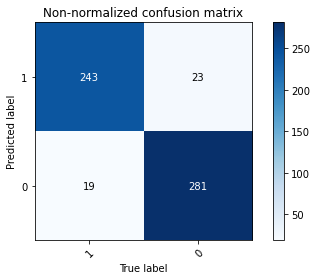

In [12]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred) # transpose such that true labels are columns and predicted is row
    tn, fp, fn, tp = cm.ravel()
    cm = np.array([[tp, fp], [fn, tn]])
    print(tn, fp, fn, tp)
    # Only use the labels that appear in the data
    print("Classes before:", classes)
    print("unique labels:", unique_labels(y_true, y_pred))
    classes = classes[unique_labels(y_true, y_pred)]
    print("Classes:", classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Predicted label',
           xlabel='True label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



np.set_printoptions(precision=2)

#class_names = np.array(["M", "F", "U"])
class_names = np.array(["1", "0"])

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Non-normalized confusion matrix')

plt.savefig("ConfusionMatrix_nonNormalized_personalTweet.png", bbox_inches="tight")

plt.show()

281 23 19 243
Classes before: ['1' '0']
unique labels: [0 1]
Classes: ['1' '0']
Normalized confusion matrix
[[0.91 0.09]
 [0.06 0.94]]


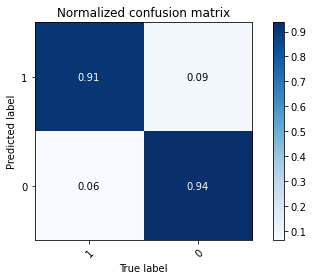

In [6]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.savefig("ConfusionMatrix_Normalized_personalTweet.png", bbox_inches="tight")

plt.show()